# T2_Genetic Information Process Model(RDME)

Here we create a simple model includes the simple central metaoblism:

In [1]:
import jLM
from jLM.RegionBuilder import RegionBuilder
from jLM.RDME import Sim as RDMESim
from jLM.RDME import File as RDMEFile

import lm
from lm import IntMpdRdmeSolver


import numpy as np

# 1. Create the RDME simulation Object

In [2]:
totalTime = 6300            # total simulation time, in seconds
timeStep = 50e-6            # time step, in seconds
writeInterval = 20000        # the times steps write the info into trajectories, units of timeStep, 20000 * 50e-6 = 1s

In [3]:
from pyLM import LMLogger
LMLogger.setLMLogConsole()
#(logging.DEBUG)

In [4]:
lattice_spacing = 8e-9 #m
N_edges = [64, 64, 64]
sim_center = [int(N_edges[0]/2),int(N_edges[1]/2),int(N_edges[2]/2)]
N_2_x=int(N_edges[0]/2)
N_2_y=int(N_edges[1]/2)
N_2_z=int(N_edges[2]/2)

filename = 'T2GIP_result.lm'

In [5]:
sim = RDMESim("T2_GIP",
                  filename,
                  N_edges,
                  lattice_spacing,
                  "extracellular")

sim.timestep = timeStep
sim.simulationTime=totalTime
sim.latticeWriteInterval=writeInterval
sim.speciesWriteInterval=writeInterval

sim.transitionRate(None, None, None, sim.diffusionZero)

# 2. Build up the Minimal Cell Spatial Geometry

In [6]:
radius_nm = 2.00e-7 #m minimal cell radius
cyto_radius = radius_nm/sim.latticeSpacing  #converted to lattice sites, # of lattice sites from the center to the edge of the cell

In [7]:
build = RegionBuilder(sim)

# create a sphere region as the cytoplasm
cytoplasm = build.ellipsoid(radius = cyto_radius, center = sim_center)
# create a spherical surface  as the shell region of the cell
cyto_dilation = build.dilate(cytoplasm, se = build.se26)
shell = cyto_dilation & ~cytoplasm

# create a spherical surface as the membrane 
cyto_dilation = build.dilate(cyto_dilation, se = build.se26)
membrane = cyto_dilation & ~shell & ~cytoplasm

randomly place 500 ribosomes in cytoplasm:

In [8]:
import T2_loading as loader

ribosomes = loader.getRibosomeSites(cytoplasm, N_edges)

Load the geometry of DNA from file

In [9]:

# Load the DNA file generated from b-Tree Chromo
DNAfile = './supporting_data/x_chain_syn3a_rep00001.bin'# DNA bin file

DNAsites, DNA_pos = loader.getDNAsites(DNAfile, N_edges,lattice_spacing, N_2_x, N_2_y, N_2_z)

# define cyto plasm and extra cellular region
cytoplasm = cytoplasm & ~DNAsites
extracellular = ~membrane & ~cytoplasm & ~ribosomes & ~DNAsites


In [10]:
build.compose(
    (sim.region('extracellular'), extracellular),
    (sim.region('cytoplasm'), cytoplasm),
    (sim.region('DNA'),DNAsites),
    (sim.region('ribosomes'), ribosomes),
    (sim.region('shell'), shell),
    (sim.region('membrane'), membrane))

In [11]:
ext=sim.region('extracellular')
cyt=sim.region('cytoplasm')
dna=sim.region('DNA')
ribo=sim.region('ribosomes')
she=sim.region('shell')
mem=sim.region('membrane')

In [12]:
sim.displayGeometry()

# 3. Define all species

In [13]:
with sim.construct():
    sim.species("gene", texRepr="gene", annotation="gene in gene info process")
    sim.species("mRNA", textRepr="mRNA", annotation="mRNA in gene info process")
    sim.species("mRNAr", textRepr="mRNA_{read}", annotation="mRNA after the translation")
    sim.species("P", texRepr="Protein", annotation="Protein in gene info process")

In [14]:
sp = sim.sp   # species object access
reg = sim.reg # region object access
rc = sim.rc   # rate constant object access
dc = sim.dc   # diffusion constant object access

In [15]:
sim.transitionRate(None, None, None, sim.diffusionZero)

# 4. Define reactions and diffusions

After the mRNA transcribed from the gene represented as a particle in the Gene start site in the 3 dimensional lattice; we only allow mRNA to diffuse out of the `DNA` region to `cytoplasm` and we don't allow the particle to diffuse within the `DNA` region.

We also need to allow the mRNA to diffuse into the ribosome and out-of ribosome for the translation. Here, to prevent the mRNA getting trapped inside the `ribosomes`, and constantly translating, we form a new particle called $mRNA_{read}$.

$mRNA_{read}$ can be instantly convert back to $m_{RNA}$ out side `ribosomes`.

In [16]:
with sim.construct():
    sim.rateConst("trans", 0.019, order=1, annotation="transcription rate")
    sim.rateConst("transl", 0.0029, order=1, annotation="translation rate")
    sim.rateConst("degrad_m", 0.0023, order=1, annotation="mRNA degradation rate")
    sim.rateConst("degrad_p", 7.7e-6, order=1, annotation="Protein degradation rate")
    sim.rateConst("conversion", 1000000, order= 1, annotation="Conversion rate from mRNA read state to ready state")
    # define all necessary reactions
    # transcription
    sim.reaction([sp.gene], [sp.gene, sp.mRNA], rc.trans, regions=[reg.DNA], annotation="transcription")
    # mRNA degradation
    sim.reaction([sp.mRNA], [], rc.degrad_m, regions=[reg.shell], annotation="mRNA degradation")
    sim.reaction([sp.mRNAr],[], rc.degrad_m, regions=[reg.shell], annotation="mRNA read degradation")
    # translation
    sim.reaction([sp.mRNA], [sp.mRNAr, sp.P], rc.transl, regions=[reg.ribosomes], annotation="translation")
    # protein degradation
    sim.reaction([sp.P], [], rc.degrad_p, regions=[reg.shell], annotation="Protein degradation")
    
    # conversion from mRNA read state to ready state
    sim.reaction([sp.mRNAr], [sp.mRNA], rc.conversion, regions=[reg.shell, reg.cytoplasm], annotation="Conversion from mRNA read state to ready state")

now we need all the diffusion coefficients defined:

In [17]:
with sim.construct():
    sim.transitionRate(None, None, None, sim.diffusionZero)

In [18]:
with sim.construct():
    sim.diffusionConst('mrna',4.13e-14, texRepr=r'D_{mRNA}', annotation="mRNA diffusion constant for JCVISYN3A_0001")
    sim.diffusionConst('protein', 1.00e-12, texRepr=r'Protein', annotation="protein diffusion co.")
    # diffusion for mrna 
    sim.transitionRate(sp.mRNA, reg.DNA, reg.cytoplasm, dc.mrna)
    sim.transitionRate(sp.mRNA, reg.cytoplasm, reg.ribosomes, dc.mrna)
    sim.transitionRate(sp.mRNA, reg.cytoplasm, reg.cytoplasm, dc.mrna)
    sim.transitionRate(sp.mRNA, reg.ribosomes, reg.ribosomes, dc.mrna)
    # diffusion for mrna_read, it is the read state after the mrna translation,
    # mrna_read formed in ribsomes, and conversion happen in cytoplasm and shell
    # so we must allow it to diffuse in cytoplasm and shell
    sim.transitionRate(sp.mRNAr, reg.ribosomes, reg.ribosomes, dc.mrna)
    sim.transitionRate(sp.mRNAr, reg.ribosomes, reg.cytoplasm, dc.mrna)
    sim.transitionRate(sp.mRNAr, reg.ribosomes, reg.shell, dc.mrna)
    sim.transitionRate(sp.mRNAr, reg.cytoplasm, reg.cytoplasm, dc.mrna)
    sim.transitionRate(sp.mRNAr, reg.cytoplasm, reg.shell, dc.mrna)
    sim.transitionRate(sp.mRNAr, reg.shell, reg.shell, dc.mrna)
    sim.transitionRate(sp.mRNAr, reg.shell, reg.cytoplasm, dc.mrna)
    
    # diffusion for protein
    sim.transitionRate(sp.P, reg.ribosomes, reg.ribosomes, dc.protein)
    sim.transitionRate(sp.P, reg.ribosomes, reg.cytoplasm, dc.protein)
    sim.transitionRate(sp.P, reg.ribosomes, reg.shell, dc.protein)
    sim.transitionRate(sp.P, reg.cytoplasm, reg.cytoplasm, dc.protein)
    sim.transitionRate(sp.P, reg.cytoplasm, reg.shell, dc.protein)
    sim.transitionRate(sp.P, reg.shell, reg.shell, dc.protein)
    sim.transitionRate(sp.P, reg.shell, reg.cytoplasm, dc.protein)

# 5. Initial counts

We need one DNA particle in the starting site to represent gene. Since our gene is JCVISYN3A_0001, we put the gene particle in the first lattice cube of DNA_region.

Other species inital counts all set to be 0:

#mRNA = #mRNA_read = 0

#Protein = 0

In [19]:
gene_pos = DNA_pos[0]
sim.placeNumber(sp=sp.gene,x=gene_pos[0], y=gene_pos[1], z=gene_pos[2], n=1)

In [20]:
sim.showAllSpecies()


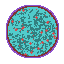

In [21]:
sim

In [22]:
sim.finalize()

# 6. Run the simulation

2024-04-28 15:29:15) Info: Using 32 processor(s) and 1 CUDA device(s) per process.
2024-04-28 15:29:15) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-04-28 15:29:15) Info: Data output thread running.
2024-04-28 15:29:15) ERROR: Exception during execution of replicate: Invalid argument: D, The specified diffusion coefficient is too high for the diffusion model..
2024-04-28 15:29:15) Info: Data output thread finished.
2024-04-28 15:29:15) Info: Simulation file closed.



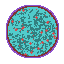

In [23]:
sim.run(solver=IntMpdRdmeSolver(), cudaDevices=[1])

In [24]:
import matplotlib.pyplot as plt

In [25]:
traj = RDMEFile(filename,replicate=1)
times= traj.speciesCountTimes
# print(times)
# print(times[-1],times[-1]/60)
# times=np.arange(0,simTime+1)
times=times/60.0 #convert to mins
simTime=int(times[-1])
print(simTime,'mins')
simTime=simTime*60
sL= [x.name for x in traj.speciesList]
sL

AttributeError: 'File' object has no attribute 'speciesCountTimes'

In [ ]:
traces=np.zeros((len(sL),len(times)))

for i,s in enumerate(sL):
        t,trace=traj.getNumberTrajectory(species = traj.species(s))
        traces[i]=trace

A
B
C
D
E


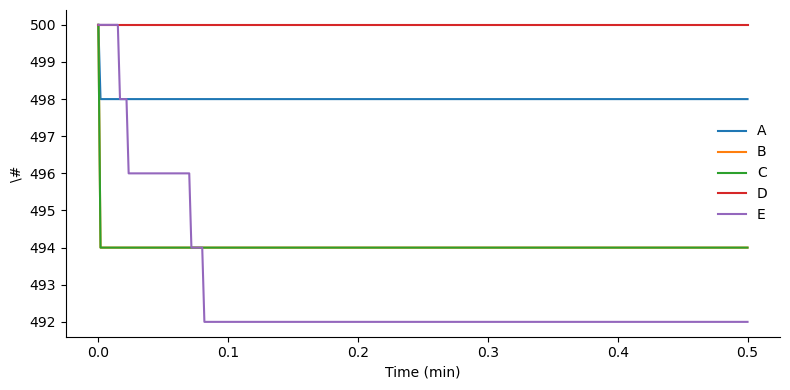

In [ ]:
fig,ax=plt.subplots(1,figsize=(8,4))

for spcID in ['A','B','C','D','E']:
    print(spcID)
    plt.plot(times,traces[sL.index(spcID)],label=spcID)


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Time (min)')
ax.set_ylabel('\#')
plt.legend().get_frame().set_alpha(0)
plt.tight_layout()
plt.show()

A3 0.0
B3 0.0
C3 0.0
D3 0.0
E3 0.0


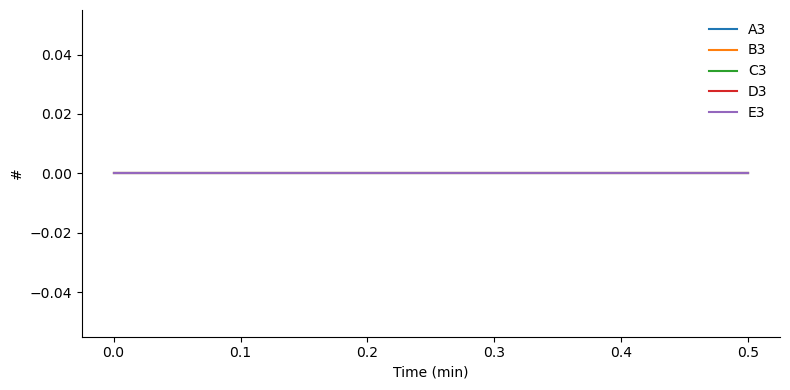

In [ ]:
fig,ax=plt.subplots(1,figsize=(8,4))

for spcID in ['A','B','C','D','E']:
    spcID=spcID+'3'
    print(spcID,traces[sL.index(spcID)][-1]/initN)
    
    plt.plot(times,traces[sL.index(spcID)],label=spcID)


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Time (min)')
ax.set_ylabel('#')
plt.legend().get_frame().set_alpha(0)
plt.tight_layout()
plt.show()